# Efficiently run SetFit Models with Optimum

In [1]:
from pathlib import Path
from time import perf_counter
import os
import sys

import evaluate
import numpy as np
import torch
from torch.utils.data import DataLoader

metric = evaluate.load("accuracy")

os.environ["TOKENIZERS_PARALLELISM"] = "false"

class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type
        self.enable_autocast = 'optimum' in self.optim_type.lower()
        
    def compute_accuracy(self):
        with torch.cpu.amp.autocast(enabled=self.enable_autocast):
            preds = self.model.predict(self.dataset["text"])
        labels = self.dataset["label"]
        accuracy = metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.model.model_body.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def compute_latency(self, query="that loves its characters and communicates something rather beautiful about human nature"):
        latencies = []
        # Warmup
        for _ in range(10):
            with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                _ = self.model([query])
        # Timed run
        for _ in range(1000):
            start_time = perf_counter()
            with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                _ = self.model([query])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(rf"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def compute_throughput(self, batch_sizes=[64, 512, 8192]):
        results = {}
        num_iters = 5
        replications = int((max(batch_sizes) * (num_iters + 1)) / len(self.dataset))
        replicated_ds = (self.dataset["text"] * replications)[:max(batch_sizes) * num_iters]

        s = ""
        for batch_size in batch_sizes:
            print(f"Batch size: {batch_size}")
            
            throughputs = []
            dataloader = iter(DataLoader(replicated_ds, batch_size=batch_size))
            # Warmup
            for _ in range(2):
                with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                    _ = self.model(next(dataloader))

            dataloader = iter(DataLoader(replicated_ds, batch_size=batch_size))
            # Timed run
            num_loops = num_iters * (max(batch_sizes) / batch_size)
            assert int(num_loops) == num_loops
            
            for _ in range(int(num_loops))::
                start_time = perf_counter()
                with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                    _ = self.model(next(dataloader))
                latency =  perf_counter() - start_time
                throughputs.append(batch_size / latency)
                
            # Compute run statistics
            avg_throughput = np.mean(throughputs)
            std_throughput = np.std(throughputs)
            print(rf"Average throughput (bs={batch_size}) (samples/second): {avg_throughput:.2f} +\- {std_throughput:.2f}\n")
            results[f"throughput_avg_{batch_size}"] = avg_throughput
            results[f"throughput_std_{batch_size}"] = std_throughput
        return results
        
    def run_benchmark(self):
        metrics = {self.optim_type: {}}
        metrics[self.optim_type].update(self.compute_size())
        metrics[self.optim_type].update(self.compute_accuracy())
        metrics[self.optim_type].update(self.compute_latency())
        metrics[self.optim_type].update(self.compute_throughput())
        return metrics

In [2]:
# TODO: Add code for quantizing the model "moshew/bge-small-en-v1.5_setfit-sst2-english" using INC

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(perf_metrics):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        plt.errorbar(
            df_opt["time_avg_ms"],
            df_opt["accuracy"] * 100,
            xerr=df_opt["time_std_ms"],
            fmt="o",
            alpha=0.5,
            ms=df_opt["size_mb"] / 15,
            label=idx,
            capsize=5,
            capthick=1,
        )

    legend = plt.legend(loc="lower right")

    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = max([metrics["time_avg_ms"] for metrics in perf_metrics.values()]) * 1.3
    plt.xlim(0, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency with batch_size=1 (ms)")
    plt.show()

Model size (MB) - 127.32
Accuracy on test set - 0.906
Average latency (ms) - 7.86 +\- 0.82
Batch size: 64


  0%|          | 0/640 [00:00<?, ?it/s]

Average throughput (bs=64) (samples/second): 652.26 +\- 72.70\n
Batch size: 512


  0%|          | 0/80 [00:00<?, ?it/s]

Average throughput (bs=512) (samples/second): 1023.17 +\- 128.72\n
Batch size: 8192


  0%|          | 0/5 [00:00<?, ?it/s]

Average throughput (bs=8192) (samples/second): 1449.02 +\- 119.12\n


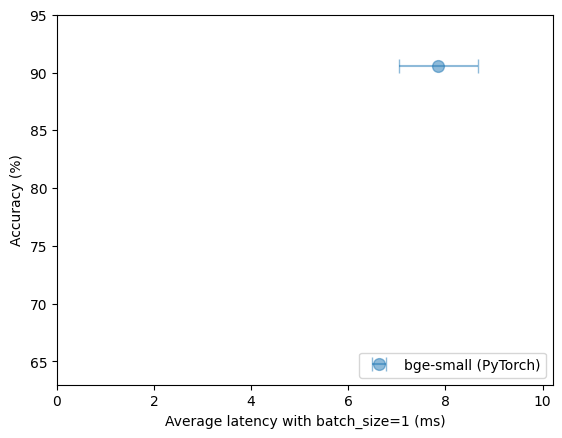

In [4]:
import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset
test_dataset = load_dataset("SetFit/sst2")["validation"]
from setfit import SetFitModel
small_model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
pb = PerformanceBenchmark(model=small_model, dataset=test_dataset, optim_type="bge-small (PyTorch)")
perf_metrics = pb.run_benchmark()
plot_metrics(perf_metrics)

## 4. Optimizing with [`optimum-intel`](https://github.com/huggingface/optimum-intel)

In [5]:
!pip install torch==2.1 --index-url https://download.pytorch.org/whl/cpu -qqq
!pip install intel-extension-for-pytorch
!pip install intel-openmp
!pip install optimum[neural-compressor] --upgrade-strategy eager

In [6]:
from setfit.exporters.utils import mean_pooling

class INCSetFitModel:
    def __init__(self, inc_model, tokenizer, model_head):
        self.inc_model = inc_model
        self.tokenizer = tokenizer
        self.model_head = model_head

    def predict(self, inputs):
        encoded_inputs = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        ).to(self.inc_model.device)

        outputs = self.inc_model(**encoded_inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], encoded_inputs["attention_mask"]
        )
        return self.model_head.predict(embeddings.cpu())

    def __call__(self, inputs):
        return self.predict(inputs)

In [7]:
from optimum.intel import INCModel
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bge_auto_opt_O4', model_max_length=512)
inc_model_path = "/home/sdp/dkorat/fastRAG/scripts/optimizations/embedders/quantized_model"
inc_model = INCModel.from_pretrained(inc_model_path)
model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
inc_setfit_model = INCSetFitModel(inc_model, tokenizer, model.model_head)

# Perform inference
inc_setfit_model(test_dataset["text"][:5])

/storage/sdp/anaconda3/envs/setfit/lib/python3.10/site-packages/neural_compressor/utils/utility.py:46: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/storage/sdp/anaconda3/envs/setfit/lib/python3.10/site-packages/neural_compressor/experimental/common/criterion.py:430: DeprecationWarning: Call to deprecated function (or staticmethod) criterion_registry. -- Deprecated since version 2.0.
  @criterion_registry("KnowledgeDistillationLoss", "pytorch")
/storage/sdp/anaconda3/envs/setfit/lib/python3.10/site-packages/neural_compressor/experimental/common/criterion.py:963: DeprecationWarning: Call to deprecated function (or staticmethod) criterion_registry. -- Deprecated since version 2.0.
  @criterion_registry("IntermediateLayersKnowledgeDistillationLoss", "pytorch")
/storage/sdp/anaconda3/envs/setfit/lib/python3.10/site-packages/neural_compressor/experimental/common/optimizer.py:1

array([0, 0, 0, 0, 1])

Time to benchmark this ONNX model.

Model size (MB) - 0.004
Accuracy on test set - 0.908
Average latency (ms) - 2.61 +\- 1.15
Batch size: 64


  0%|          | 0/640 [00:00<?, ?it/s]

Average throughput (bs=64) (samples/second): 1942.65 +\- 555.73\n
Batch size: 512


  0%|          | 0/80 [00:00<?, ?it/s]

Average throughput (bs=512) (samples/second): 2424.35 +\- 472.96\n
Batch size: 8192


  0%|          | 0/5 [00:00<?, ?it/s]

Average throughput (bs=8192) (samples/second): 4978.16 +\- 290.23\n
bge-small (PyTorch):
size_mb: 127.324
accuracy: 0.906
time_avg_ms: 7.856
time_std_ms: 0.820
throughput_avg_64: 652.260
throughput_std_64: 72.695
throughput_avg_512: 1023.175
throughput_std_512: 128.715
throughput_avg_8192: 1449.017
throughput_std_8192: 119.124

bge-small (optimum-intel):
size_mb: 0.004
accuracy: 0.908
time_avg_ms: 2.610
time_std_ms: 1.153
throughput_avg_64: 1942.650
throughput_std_64: 555.732
throughput_avg_512: 2424.352
throughput_std_512: 472.964
throughput_avg_8192: 4978.163
throughput_std_8192: 290.228



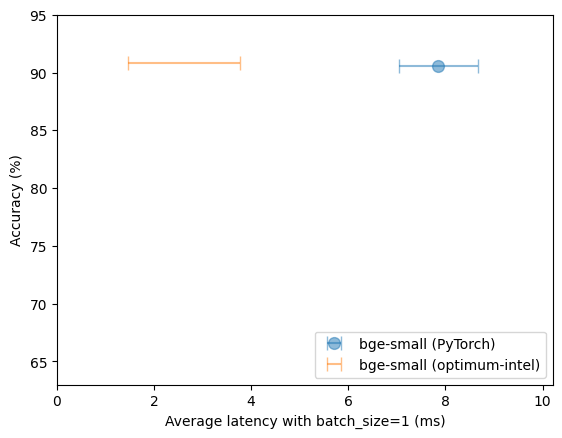

Latency speedup for 'bge-small (optimum-intel)': 3.01x


In [8]:
class INCPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.3f}")
        return {"size_mb": size_mb}
        
pb = INCPerformanceBenchmark(
    inc_setfit_model,
    test_dataset,
    "bge-small (optimum-intel)",
    model_path=inc_model_path,
)
perf_metrics.update(pb.run_benchmark())

for optim_type, results in perf_metrics.items():
    s = [f"{k}: {v:.3f}" for k, v in results.items()]
    print(f"{optim_type}:\n" + "\n".join(s) + "\n")
    
plot_metrics(perf_metrics)

def get_latency_speedup(model_name):
    speedup = perf_metrics['bge-small (PyTorch)']['time_avg_ms'] / perf_metrics[model_name]['time_avg_ms']
    return speedup
print(f"Latency speedup for 'bge-small (optimum-intel)': {get_latency_speedup('bge-small (optimum-intel)'):.2f}x")

## 5. Optimizing for CPU using Intel Extension for Pytorch


In [9]:
# !pip install torch==2.1 --index-url https://download.pytorch.org/whl/cpu -qqq
# !pip install intel-extension-for-pytorch==2.1.0 intel-openmp==2024.0.0 -qqq

In [10]:
# !conda install gperftools -c conda-forge -y -qqq
# !echo export LD_PRELOAD=${CONDA_PREFIX}/lib/libtcmalloc.so:${CONDA_PREFIX}/lib/libiomp5.so:$LD_PRELOAD >> ~/.bashrc
# Restart kernel after this cell!!!

In [11]:
# Without conda, run these commands in the shell and restart this notebook

# wget https://github.com/gperftools/gperftools/releases/download/gperftools-2.7.90/gperftools-2.7.90.tar.gz
# tar -xzf gperftools-2.7.90.tar.gz 
# cd gperftools-2.7.90
# ./configure --prefix=$HOME/.local
# make
# make install
# echo export LD_PRELOAD=$HOME/.local/lib/libtcmalloc.so:$VIRTUAL_ENV/lib/libiomp5.so:$LD_PRELOAD >> ~/.bashrc

In [12]:
# import intel_extension_for_pytorch as ipex

# pb = PerformanceBenchmark(model=setfit_model, dataset=test_dataset, optim_type="bge-small (IP import only)")
# perf_metrics = pb.run_benchmark()

In [13]:
# from setfit import SetFitModel
# setfit_model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")

# pb = PerformanceBenchmark(model=setfit_model, dataset=test_dataset, optim_type="bge-small (Pytorch)")
# perf_metrics.update(pb.run_benchmark())

In [14]:
# import intel_extension_for_pytorch as ipex
# from setfit import SetFitModel

# ipex_model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
# with torch.autocast('cpu', dtype=torch.bfloat16):
#     ipex_model.model_body.eval()
#     ipex_model.model_body = ipex.optimize(ipex_model.model_body, weights_prepack=False, dtype=torch.bfloat16)
#     ipex_model.model_body = torch.compile(ipex_model.model_body, backend='ipex')

# pb = PerformanceBenchmark(model=ipex_model, dataset=test_dataset, optim_type="bge-small (IPEX)")
# ipex_result_str = pb.run_benchmark()[1]

In [15]:
# print(f"Pytorch\n-----\n{pytorch_result_str}")
# print()
# print(f"IPEX\n-----\n{ipex_result_str}")